In [1]:
import numpy as np
import pandas as pd

In [2]:
# get data
X_train: pd.DataFrame = pd.read_csv("../X_train.csv")
y_train: pd.DataFrame = pd.read_csv("../y_train.csv")

X_test_1: pd.DataFrame = pd.read_csv("../X_test_1.csv")
# which will be tested against y_test_1

# y_test_2 provides labels for first 202 rows in X_test_2
X_test_2: pd.DataFrame = pd.read_csv("../X_test_2.csv")
y_test_2: pd.DataFrame = pd.read_csv("../y_test_2_reduced.csv")

print(X_train.shape, y_train.shape)
print(X_test_2.shape, y_test_2.shape)

(10000, 300) (10000, 1)
(2020, 300) (202, 1)


In [3]:
# select features
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
def threshold_variance(this_X: pd.DataFrame, threshold=0.1):
    # remove low variance
    variance_selector = VarianceThreshold(threshold=threshold)
    X_reduced = variance_selector.fit_transform(this_X)

    # get feature names that passed the threshold
    selected_features = this_X.columns[variance_selector.get_support()]

    # optionally scale after thresholding
    X_scaled = StandardScaler().fit_transform(X_reduced)

    print(f"Threshold reduced shape: {X_scaled.shape}")
    return X_scaled, selected_features


In [5]:
# table of class distribution in y_train
y_train_distribution = y_train.value_counts().reset_index()
y_train_distribution.columns = ['class', 'count']
print(y_train_distribution)

    class  count
0       5   4479
1      10   1081
2       6    553
3       8    516
4      12    457
5      24    385
6      17    354
7      26    278
8      21    269
9      14    264
10      4    238
11     25    184
12     19    177
13     20    153
14     27    107
15      7    103
16     11     78
17      3     65
18     13     62
19     18     60
20     23     41
21     15     26
22      9     25
23      0     18
24      1      7
25     22      7
26      2      7
27     16      6


In [6]:
# use smote?
smote = SMOTE(random_state=42)
X = X_train.copy().to_numpy()
y = y_train.copy().to_numpy().reshape(-1)
X, y = smote.fit_resample(X, y)
if smote:
    print(f"SMOTE generated an additional {X.shape[0] - X_train.shape[0]} samples.")
    y_resampled_distribution = pd.DataFrame(y).value_counts().reset_index()
    y_resampled_distribution.columns = ["class", "count"]
    print(y_resampled_distribution)

SMOTE generated an additional 115412 samples.
    class  count
0       0   4479
1       1   4479
2      26   4479
3      25   4479
4      24   4479
5      23   4479
6      22   4479
7      21   4479
8      20   4479
9      19   4479
10     18   4479
11     17   4479
12     16   4479
13     15   4479
14     14   4479
15     13   4479
16     12   4479
17     11   4479
18     10   4479
19      9   4479
20      8   4479
21      7   4479
22      6   4479
23      5   4479
24      4   4479
25      3   4479
26      2   4479
27     27   4479


In [7]:
# create pipeline

# estimator = RandomForestClassifier(criterion="entropy") takes too long
estimator = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    class_weight=None, # None for SMOTE, "balanced" for no SMOTE
    random_state=42
)

cv = StratifiedKFold(n_splits=4)

rfecv = RFECV(
    estimator=estimator,
    step=10,
    cv=cv,
    scoring="f1_macro", # f1 weighted for multiclass imbalance too (when not using smote)
    n_jobs=-1
)

train_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feature_selection", rfecv),
    ("classifier", estimator)
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_pipeline.fit(X_train, y_train)
y_pred = train_pipeline.predict(X_val)
y_proba = train_pipeline.predict_proba(X_val)

In [8]:
n_features = train_pipeline.named_steps['feature_selection'].n_features_
print(f"Number of features selected: {n_features}")

Number of features selected: 300


In [9]:
support_mask = train_pipeline.named_steps['feature_selection'].support_
selected_feature_indices = np.where(support_mask)[0]
print(f"Selected feature indices: {selected_feature_indices}")

Selected feature indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 

In [11]:
def plot_confusion_matrix(this_y_val, this_y_pred, classes=range(28), normalize=True, title="Confusion Matrix (Validation Set)"):
    cm = confusion_matrix(this_y_val, this_y_pred)

    class_labels = [f"Class {i}" for i in classes]
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".1f", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

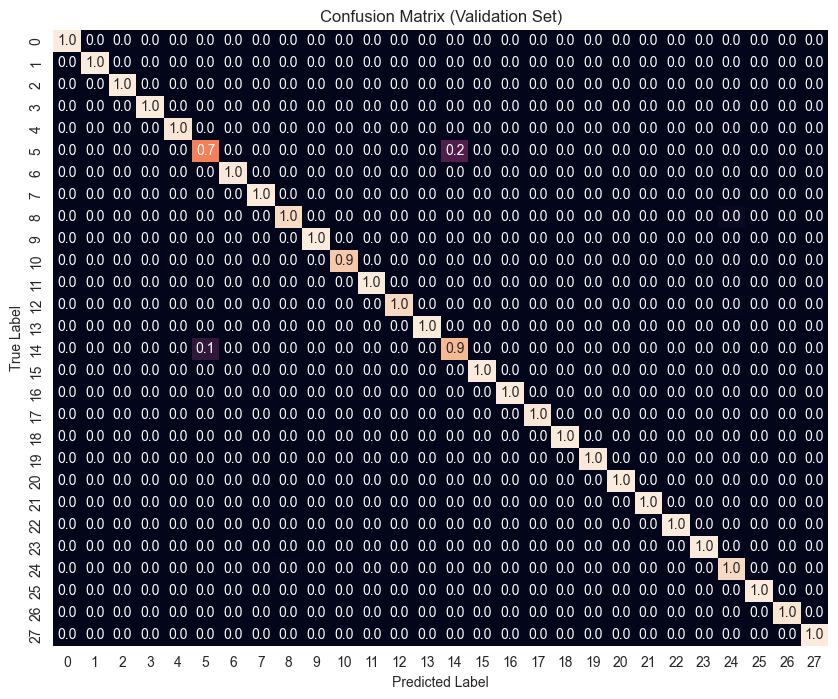

In [12]:
plot_confusion_matrix(y_val, y_pred, classes=range(28), normalize=True, title="Confusion Matrix (Validation Set)")

In [13]:
print(classification_report(y_pred=y_pred, y_true=y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       895
           1       1.00      1.00      1.00       896
           2       1.00      1.00      1.00       896
           3       1.00      1.00      1.00       896
           4       0.98      0.99      0.99       896
           5       0.83      0.73      0.78       896
           6       0.99      0.99      0.99       896
           7       0.98      1.00      0.99       896
           8       0.96      0.96      0.96       895
           9       1.00      1.00      1.00       895
          10       0.97      0.91      0.94       896
          11       1.00      1.00      1.00       896
          12       0.96      0.95      0.96       896
          13       0.99      1.00      1.00       896
          14       0.80      0.87      0.83       896
          15       1.00      1.00      1.00       896
          16       1.00      1.00      1.00       896
          17       0.98    

In [20]:
# test against test_2 (unexpected model performance)
X_test_2_labelled = X_test_2.copy()[:202] # only labelled
print(X_test_2_labelled.shape)
y_pred_2 = train_pipeline.predict(X_test_2_labelled.to_numpy())

(202, 300)


In [21]:
print(classification_report(y_pred=y_pred_2, y_true=y_test_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.43      0.75      0.55         4
           5       0.50      0.67      0.57         9
           6       0.50      0.67      0.57         3
           7       0.75      0.43      0.55        14
           8       0.74      0.59      0.65        29
           9       0.00      0.00      0.00         3
          10       0.17      1.00      0.29         2
          11       0.89      0.89      0.89         9
          12       0.69      0.51      0.59        43
          13       0.14      1.00      0.25         1
          14       0.33      0.33      0.33         6
          15       0.00      0.00      0.00         1
          17       0.78      0.70      0.74        10
          18       0.00      0.00      0.00         1
          19       0.50    

/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/archiecollison/Developer/cse/cs9417/project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

/var/folders/f2/41dfqkfn37jdnzpl74jrw37r0000gn/T/ipykernel_3825/2250770255.py:5: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


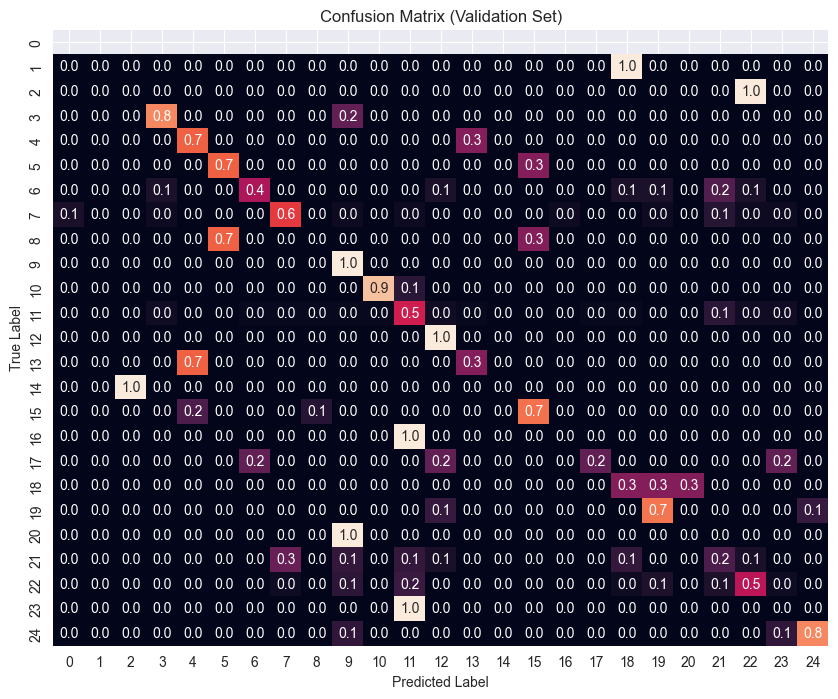

In [19]:
plot_confusion_matrix(y_test_2, y_pred_2, classes=range(28), normalize=True, title="Confusion Matrix (Unexpected Model Performance Set)")

# Overview
SMOTE helped improve original train/test performance. It used augmentation to generate an additional 115412 training samples for 4479 samples per class.
We achieve (on validation set):
- weighted, macro precision, recall and f1-score of 0.97.

However, on the unexpected test set:
- precision, recall, f1-score all tanked
- this indicates a struggle to generalise to new data.
- this could be due to overfitting (smote generated too much data?), concept drift, or the model memorising patterns only present in the test data
